In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-sales-report/Car Sales.xlsx - car_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [11]:
!pip install pulp

In [3]:
# Load the dataset
data = pd.read_csv('/kaggle/input/car-sales-report/Car Sales.xlsx - car_data.csv')  

# Preview the first few rows of the dataset
data.head()

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [4]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Fill missing values (example for numeric and categorical columns)
data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].median())
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])

# Ensure categorical data types
categorical_cols = ['Gender', 'Dealer_Region', 'Company', 'Model', 'Color']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Check the cleaned data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Car_id         23906 non-null  object        
 1   Date           23906 non-null  datetime64[ns]
 2   Customer Name  23905 non-null  object        
 3   Gender         23906 non-null  category      
 4   Annual Income  23906 non-null  int64         
 5   Dealer_Name    23906 non-null  object        
 6   Company        23906 non-null  category      
 7   Model          23906 non-null  category      
 8   Engine         23906 non-null  object        
 9   Transmission   23906 non-null  object        
 10  Color          23906 non-null  category      
 11  Price ($)      23906 non-null  int64         
 12  Dealer_No      23906 non-null  object        
 13  Body Style     23906 non-null  object        
 14  Phone          23906 non-null  int64         
 15  Dealer_Region  2390

In [13]:
# Importing necessary libraries
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable


In [14]:
# Calculate cost and profit
data['Cost'] = data['Price ($)'] * 0.7  # Example cost calculation (70% of price)
data['Profit'] = data['Price ($)'] - data['Cost']  # Profit = Price - Cost


In [15]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable

# Example cost calculation, assuming cost is 70% of the car price
data['Cost'] = data['Price ($)'] * 0.7
data['Profit'] = data['Price ($)'] - data['Cost']

# Decision Variables: Number of cars sold per model and dealer
models = data['Model'].unique()
decision_vars = {model: LpVariable(f"x_{model}", lowBound=0, cat="Continuous") for model in models}

# Define the Linear Programming Problem
problem = LpProblem("Maximize_Profit", LpMaximize)

# Objective function: Maximize total profit
problem += sum(decision_vars[model] * data[data['Model'] == model]['Profit'].values[0] for model in models), "Total_Profit"

# Add Constraints based on Dealer Region
for region in data['Dealer_Region'].unique():
    # Example constraint: Total cars sold per region should not exceed a certain limit (say 100)
    problem += sum(decision_vars[model] for model in data[data['Dealer_Region'] == region]['Model']) <= 100, f"Regional_Sales_Limit_{region}"

# Add Constraints based on Customer Annual Income (e.g., high-end cars should be sold to customers with higher income)
for model in models:
    # Example: Car model 'High-End' should only be sold to customers with income > $80,000
    if model == "High-End":
        problem += sum(decision_vars[model] for i, row in data[data['Model'] == model].iterrows() if row['Annual Income'] > 80000) >= 0, f"HighEnd_Model_Income_Constraint_{model}"

# Solve the problem
problem.solve()

# Output results
print(f"Status: {problem.status}")
print("Optimal Sales Allocation:")
for model, var in decision_vars.items():
    print(f"{model}: {var.value()} cars sold")

print(f"Total Profit: ${problem.objective.value()}")


Status: 1
Optimal Sales Allocation:
Expedition: 0.0 cars sold
Durango: 0.0 cars sold
Eldorado: 0.0 cars sold
Celica: 0.0 cars sold
TL: 0.0 cars sold
Diamante: 0.0 cars sold
Corolla: 0.0 cars sold
Galant: 0.0 cars sold
Malibu: 0.0 cars sold
Escort: 0.0 cars sold
RL: 0.0 cars sold
Pathfinder: 0.0 cars sold
Grand Marquis: 0.0 cars sold
323i: 0.0 cars sold
Sebring Coupe: 0.0 cars sold
Forester: 0.0 cars sold
Accent: 0.0 cars sold
Land Cruiser: 0.0 cars sold
Accord: 0.0 cars sold
4Runner: 0.0 cars sold
I30: 0.0 cars sold
A4: 0.0 cars sold
Carrera Cabrio: 0.0 cars sold
Jetta: 0.0 cars sold
Viper: 0.0 cars sold
Regal: 0.0 cars sold
LHS: 0.0 cars sold
LW: 0.0 cars sold
3000GT: 0.0 cars sold
SLK230: 0.0 cars sold
Civic: 0.0 cars sold
S-Type: 0.0 cars sold
S40: 0.0 cars sold
Mountaineer: 0.0 cars sold
Park Avenue: 0.0 cars sold
Montero Sport: 0.0 cars sold
Sentra: 0.0 cars sold
S80: 0.0 cars sold
Lumina: 0.0 cars sold
Bonneville: 0.0 cars sold
C-Class: 0.0 cars sold
Altima: 0.0 cars sold
DeVille

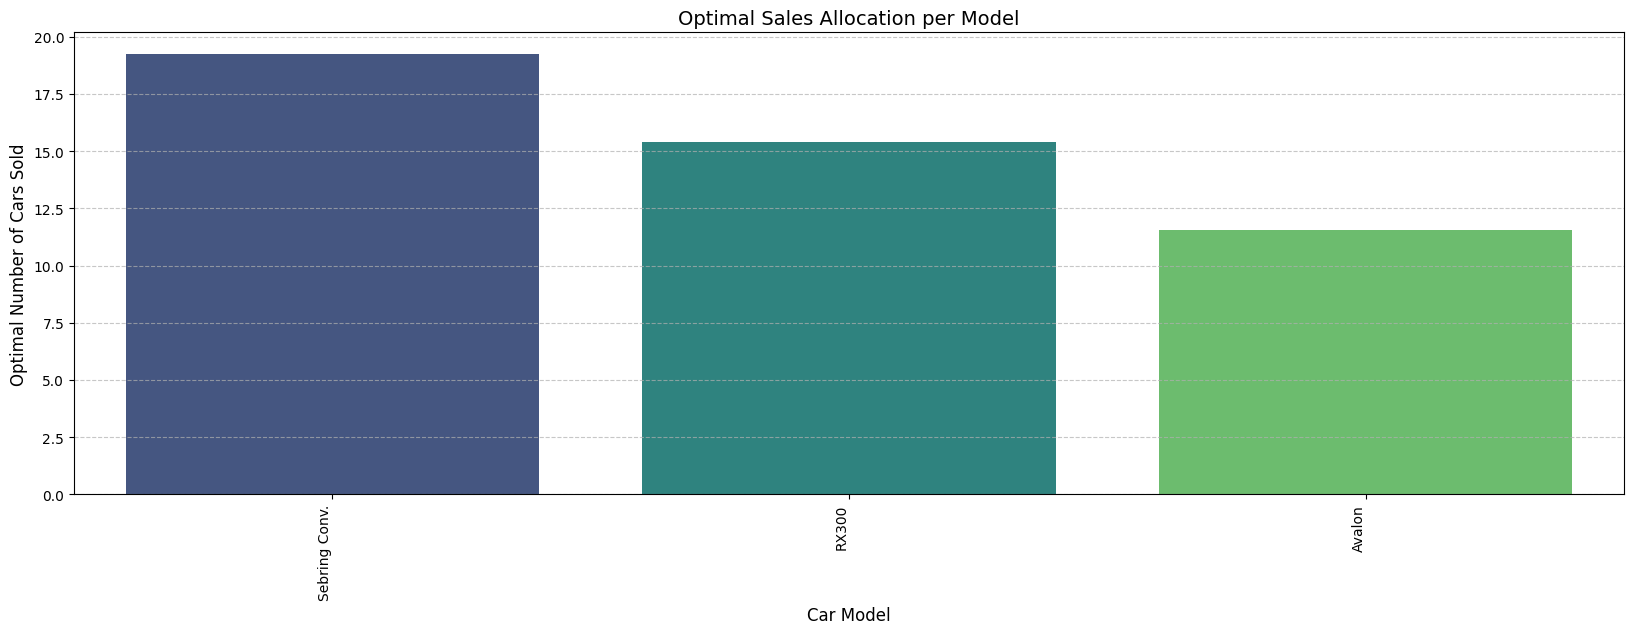

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort models by sales
optimal_sales_df_sorted = optimal_sales_df.sort_values(by="Optimal_Sales", ascending=False)

# Plot vertical bar chart
plt.figure(figsize=(20, 6))  # Increased width to fit all models
sns.barplot(x=optimal_sales_df_sorted.index, y=optimal_sales_df_sorted['Optimal_Sales'], palette="viridis")

# Rotate x-axis labels for readability
plt.xticks(rotation=90, ha='right', fontsize=10)

# Labels and title
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Optimal Number of Cars Sold", fontsize=12)
plt.title("Optimal Sales Allocation per Model", fontsize=14)

# Grid for better visualization
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


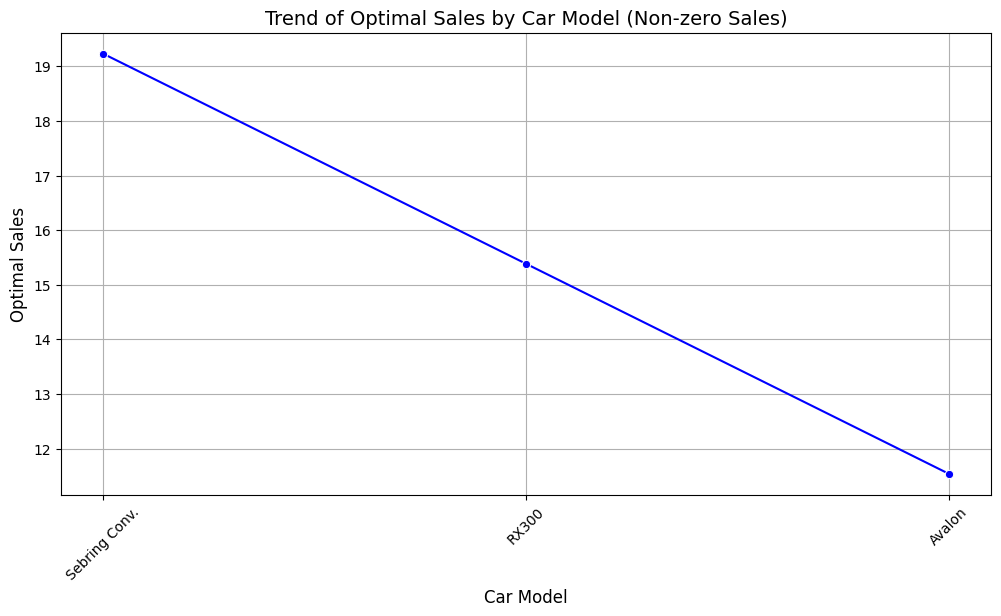

In [17]:
# Filter out models with zero sales
non_zero_sales_df = optimal_sales_df[optimal_sales_df['Optimal_Sales'] > 0]

# Line plot for non-zero sales models
plt.figure(figsize=(12, 6))
sns.lineplot(x=non_zero_sales_df.index, y=non_zero_sales_df['Optimal_Sales'], marker='o', linestyle='-', color='blue')
plt.xticks(rotation=45)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Optimal Sales", fontsize=12)
plt.title("Trend of Optimal Sales by Car Model (Non-zero Sales)", fontsize=14)
plt.grid(True)
plt.show()


Status: 1
Optimal Sales Allocation:
RX300: 15.384615 cars sold
Avalon: 11.538462 cars sold
Sebring Conv.: 19.230769 cars sold
Total Profit: $237692.30699999997


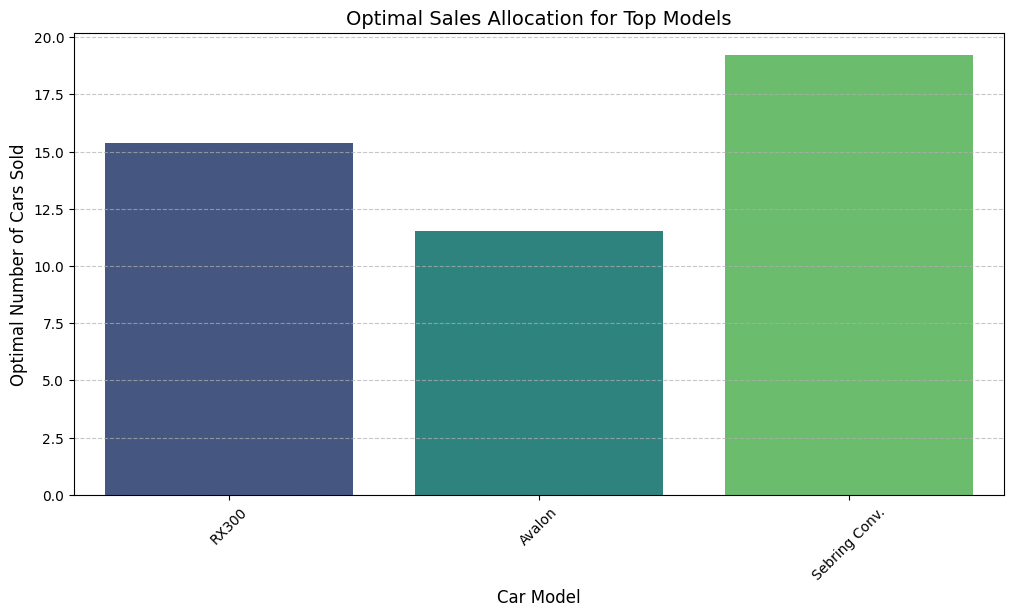

In [18]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable

# Assuming you have data loaded in the 'data' DataFrame (with 'Model', 'Price', 'Cost', etc.)

# Define the models you want to focus on (top-selling models)
top_models = ['RX300', 'Avalon', 'Sebring Conv.']

# Filter the data for the top models
top_model_data = data[data['Model'].isin(top_models)]

# Decision Variables: Number of cars sold per model
decision_vars = {model: LpVariable(f"x_{model}", lowBound=0, cat="Continuous") for model in top_models}

# Define the Linear Programming Problem
problem = LpProblem("Maximize_Profit", LpMaximize)

# Objective function: Maximize total profit (Profit = Price - Cost)
problem += sum(decision_vars[model] * top_model_data[top_model_data['Model'] == model]['Profit'].values[0] for model in top_models), "Total_Profit"

# Add Constraints: Example constraints based on inventory and regional demand

# Example: Inventory limit per model (Assume 50 units max per model)
for model in top_models:
    problem += decision_vars[model] <= 50, f"Inventory_Limit_{model}"

# Example: Regional demand constraint (Max sales in a specific region, assume max 100 cars per region)
for region in data['Dealer_Region'].unique():
    problem += sum(decision_vars[model] for model in top_model_data[top_model_data['Dealer_Region'] == region]['Model']) <= 100, f"Regional_Sales_Limit_{region}"

# Solve the problem
problem.solve()

# Output results
print(f"Status: {problem.status}")
print("Optimal Sales Allocation:")
for model, var in decision_vars.items():
    print(f"{model}: {var.value()} cars sold")

print(f"Total Profit: ${problem.objective.value()}")

# Optional: Visualize the optimal sales
optimal_sales = {model: var.value() for model, var in decision_vars.items()}
optimal_sales_df = pd.DataFrame.from_dict(optimal_sales, orient='index', columns=['Optimal_Sales'])

# Plot the results (Vertical Bar Plot for Top Models)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=optimal_sales_df.index, y=optimal_sales_df['Optimal_Sales'], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Car Model", fontsize=12)
plt.ylabel("Optimal Number of Cars Sold", fontsize=12)
plt.title("Optimal Sales Allocation for Top Models", fontsize=14)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()


# Steps followed
* Data Import: This loads dataset from a CSV file.
* Profit Calculation: I assumed a basic cost calculation (70% of price).
* Decision Variables: These represent the number of cars sold for each model.
* Objective Function: This maximizes profit, defined as Profit = Price - Cost.
* Customer Income Constraints: If a car model targets high-income customers, this constraint ensures that only customers with an income above a certain threshold will purchase the car.

